<a href="https://colab.research.google.com/github/ArmandoSep/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
# Drop columsn with high NaN values (More than 50%)
df = df.drop(['Yelp', 'Google', 'Chips', 'Mass (g)', 'Density (g/mL)', 'Length', 
             'Circum', 'Volume','Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini'], axis=1)

In [37]:
# Check for NaN values
df.isnull().sum()

Burrito          0
Date             0
Cost             7
Hunger           3
Tortilla         0
Temp            20
Meat            14
Fillings         3
Meat:filling     9
Uniformity       2
Salsa           25
Synergy          2
Wrap             3
Great            0
dtype: int64

In [0]:
df['Great'] = df['Great'].replace({True: 1, False: 0})

## Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
train = df[df['Date'].dt.year <= 2016]
val = df[df['Date'].dt.year == 2017]
test = df[df['Date'].dt.year >= 2018]

## Begin with baselines for classification.

In [41]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.590604
1    0.409396
Name: Great, dtype: float64

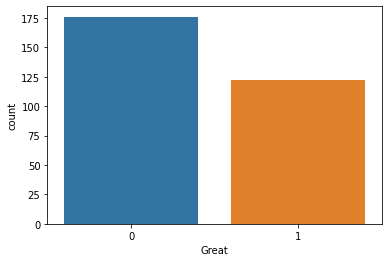

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

sns.countplot(y_train);

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [45]:
# Baseline accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_pred)

0.5906040268456376

In [46]:
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

## Use scikit-learn for logistic regression.

In [50]:
features = ['Burrito', 'Cost', 'Hunger', 'Tortilla', 'Temp', 'Meat',
       'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
target = 'Great'

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((298, 12), (298,), (85, 12), (85,))

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

# One hot encoder for categorical values
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Imputation to remove NaNs
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# Use the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)


In [56]:
# Run the logistic regresion
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Get your model's validation accuracy

In [57]:
y_pred = model.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.8235294117647058

In [58]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients

Burrito_California     0.250003
Burrito_Carnitas       0.171765
Burrito_Asada         -0.047757
Burrito_Other         -0.177691
Burrito_Surf & Turf   -0.224614
Cost                   0.390696
Hunger                 0.107966
Tortilla               0.734278
Temp                   0.582472
Meat                   1.281689
Fillings               1.174512
Meat:filling           1.365146
Uniformity             0.100400
Salsa                  0.296358
Synergy                1.687606
Wrap                   0.136124
dtype: float64

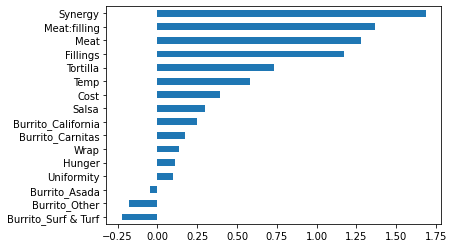

In [59]:
# Plot coefficients
coefficients.sort_values().plot.barh();

## Get your model's test accuracy

In [0]:
X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

In [63]:
y_test = test[target]
accuracy_score(y_test, y_pred)

0.7631578947368421